#### Training vector-based models

In this notebook we have experimented to classify note segments using vector-based models. We have used the following models:
- **TF-IDF + LSA**: TF-IDF is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents. LSA (Latent Semantic Analysis) is a technique that uses singular value decomposition (SVD) to reduce the dimensionality of the TF-IDF matrix, capturing the underlying structure of the data.
    - Do not capture semantic meaning of the text.
- **Doc2Vec**: Doc2Vec is an extension of Word2Vec that learns vector representations for entire documents. It captures the semantic meaning of the text by training on a large corpus of documents, allowing it to generate fixed-length vectors for variable-length texts.
    - Captures semantic meaning of the text.


Load the required libraries


In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, namedtuple
import re
from tqdm.auto import tqdm

from nltk.tokenize import word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.callbacks import CallbackAny2Vec

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
# import tensorflow.keras as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from eval_utils import create_metrics

2025-04-16 09:14:44.508485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744809284.519316 2775602 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744809284.522630 2775602 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744809284.531875 2775602 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744809284.531887 2775602 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744809284.531888 2775602 computation_placer.cc:177] computation placer alr

In [2]:
tqdm.pandas()

tf.keras.backend.clear_session()

Define constants

In [3]:

dim=50
hidden_size = 128
inname = "c_nurse"
outname = "c_nurse"

Loading datasets(segmented and normalized)

In [4]:
parts = pd.read_feather(f"dataset/{inname}-parts.feather")
titles = pd.read_feather(f"dataset/{inname}-titles.feather")

Check the shape of the datasets

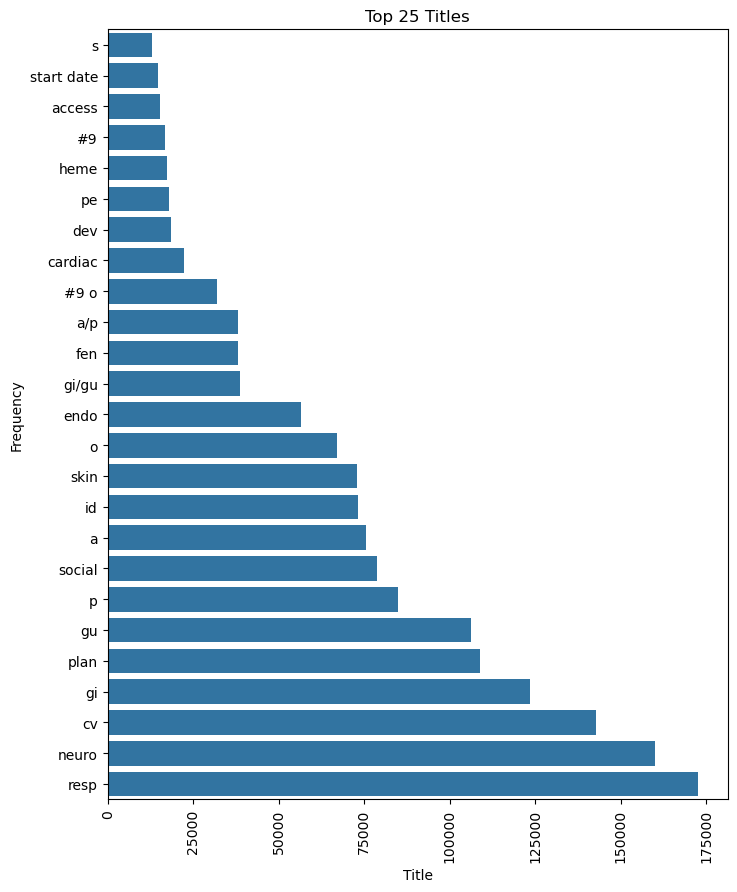

In [5]:
# plot title in x axis and freq in y axis
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 10))
sns.barplot(y="title", x="freq", data=titles.sort_values("freq").tail(25))
plt.xticks(rotation=90)
plt.title("Top 25 Titles")
plt.xlabel("Title")
plt.ylabel("Frequency")
plt.show()

Remove unlabeled data

In [6]:
# downsample
relevant = parts
relevant = relevant.query("label >= 0").reset_index(drop=True) # remove -1: unlabeled

In [7]:
relevant.head(3)


,rid,pid,rord,srord,text,stext,title,stitle,label
0,1678764,2,1,3,"PNS: A pos, Ab neg, HBSAg neg, RPR NR, RI, GB...","A pos, Ab neg, HBSAg neg, RPR NR, RI, GBS neg....",PNS,pns,183
1,1678764,2,1,6,Assessment/plan:\nTerm male infant with increa...,Term male infant with increased risk of sepsis...,Assessment/plan,assessment/plan,42
2,1260685,3,1,0,MICU NSG PROG NOTE: days\nRemains stable on hi...,"days\nRemains stable on high dose neo, taperin...",MICU NSG PROG NOTE,micu nsg prog note,700


In this processed dataset, text column contains both the text and the label. We are going to use the text+stext columns to train the model and the label column to evaluate the model. We include title in the text column with body to give the model more context/meaning.

Prepairing train/test

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# only using the first fold
for train_index, test_index in skf.split(relevant, relevant.label):
    break

Tokenizers

In [10]:
def tokenize_doc(text):
    text = re.sub(r"[0-9]", "9", text) # replace all digits with 9
    text = re.sub(r"([\.\,\:])(?!#)", r" \1 ", text) # space around punctuation
    text = re.sub(r"\n", r" <br> ", text) # Replaces newlines with <br> tag : To preserve line breaks as meaningful information / avoid issues caused by invisible characters like \n
    return text.split()

def tokenize_nltk(text):
    text = re.sub(r"[0-9]", "9", text)
    text = re.sub(r"\n", r" <br> ", text)
    return word_tokenize(text) # NLTK's word_tokenize, which is smarter than .split()


In [18]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/h6x/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
# select the tokenizer
tokenize = tokenize_nltk

Create the dataset

In [20]:
def make_dataset(relevant, indexer, tokenize_function, numproc=12):
    # Create a tokenized dataset using both original text and segmented text (stext) from the relevant object.
    df = pd.concat([
        pd.DataFrame({
            "text": relevant.text[indexer], # adding the original text for more generalization
            "label": relevant.label[indexer],
        }),
        pd.DataFrame({
            "text": relevant.stext[indexer],
            "label": relevant.label[indexer],
        })
    ]).reset_index(drop=True)

    tqdm.pandas(desc=f'  > Tokenizing')
    df["doc"] = df.text.progress_apply(tokenize_function)
    return df

In [21]:
# doubeling the dataset as we are using both text and stext and making it more general
ds = {
    "train": make_dataset(relevant, train_index, tokenize),
    "test":  make_dataset(relevant, test_index, tokenize),
}

  > Tokenizing:   0%|          | 0/3761672 [00:00<?, ?it/s]

  > Tokenizing:   0%|          | 0/940420 [00:00<?, ?it/s]

In [22]:
ds["train"].head(3)

,text,label,doc
0,MICU NSG PROG NOTE: days\nRemains stable on hi...,700,"[MICU, NSG, PROG, NOTE, :, days, <, br, >, Rem..."
1,CARDIAC: Maintaining map>60 on neo and levofed...,17,"[CARDIAC, :, Maintaining, map, >, 99, on, neo,..."
2,RESP: good abg. good oxygenation. Strong cough...,0,"[RESP, :, good, abg, ., good, oxygenation, ., ..."


### TF-IDF + LSA Classification

Vector Models --------

In [24]:
# Latent Semantic Analysis (LSA) is a technique used to uncover the hidden (latent) structure in text data by reducing its dimensionality.

In [25]:
# make LSA vectors
LSAResult = namedtuple("LSAModel", ["vectorizer", "decomposer"])

TF-IDF vectorizing

In [ ]:
vectorizer = TfidfVectorizer(lowercase=False, min_df=3)

tqdm.pandas(desc=f'  > Joining tokens')
docs = ds["train"].doc.progress_apply(" ".join) # TF-IDF in scikit-learn (and most libraries) requires input as a single string per document, not a list of tokens.

  > Joining tokens:   0%|          | 0/3761672 [00:00<?, ?it/s]

In [27]:
x = vectorizer.fit_transform(docs)

In [28]:
x.shape

(3761672, 95219)

SVD Decomposition for training

In [29]:
# dim is defined above in the beginning of the script
svd = TruncatedSVD(n_components=dim, n_iter=5, random_state=42)
vectors_lsa_train = svd.fit_transform(x)

In [30]:
# print the shape of the LSA vectors : train size, dim
vectors_lsa_train.shape

(3761672, 50)

SVD Decomposition for testing

In [31]:
docs = ds["test"].doc.progress_apply(" ".join)
vectors_lsa_test = svd.transform(vectorizer.transform(docs)) # TF-IDF and SVD 

  > Joining tokens:   0%|          | 0/940420 [00:00<?, ?it/s]

In [32]:
# print the shape of the LSA vectors : test size, dim
vectors_lsa_test.shape

(940420, 50)

In [33]:
LSAResult(vectorizer, svd)

LSAModel(vectorizer=TfidfVectorizer(lowercase=False, min_df=3), decomposer=TruncatedSVD(n_components=50, random_state=42))

Defining Classification NN for TF-IDF + LSA

In [37]:
def make_model(vectors, n_titles, dropout=0.0):
    lin = tf.keras.Input(shape=vectors[0].shape, name="input")
    x = lin
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden_size, activation="relu", name="hidden")(x)
    x = layers.Dropout(dropout)(x)
    lout = layers.Dense(n_titles, activation="sigmoid", name="prediction")(x)

    model = tf.keras.Model(lin, lout)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

Training LSA Classifier

In [35]:
nn_lsa = make_model(vectors_lsa_train, len(titles), dropout=0.0)
nn_lsa.summary()

W0000 00:00:1744810676.974945 2775602 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2121)           │       273,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,137 (1.07 MB)

 Trainable params: 280,137 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
nn_lsa.fit(
    x=vectors_lsa_train, y=ds["train"].label,
    batch_size=512,
    epochs=50,
    validation_split=0.1,
)

Epoch 1/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6375 - loss: 1.5558 - val_accuracy: 0.6364 - val_loss: 1.5933
Epoch 2/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6531 - loss: 1.4719 - val_accuracy: 0.6446 - val_loss: 1.5522
Epoch 3/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6614 - loss: 1.4226 - val_accuracy: 0.6521 - val_loss: 1.5161
Epoch 4/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6684 - loss: 1.3878 - val_accuracy: 0.6537 - val_loss: 1.5011
Epoch 5/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6729 - loss: 1.3642 - val_accuracy: 0.6581 - val_loss: 1.4854
Epoch 6/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6768 - loss: 1.3408 - val_accuracy: 0.6590 - val_loss: 1.4756
Epoch 7/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6797 - loss: 1.3273 - val_accuracy: 0.6632 - val_loss: 1.4610
Epoch 8/50
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6816 - loss: 1

Making LSA Prediction

In [39]:
import os

# Ensure the metrics directory exists
os.makedirs("metrics", exist_ok=True)

Calculating metrics: 100%|██████████| 10/10 [02:44<00:00, 16.45s/it]


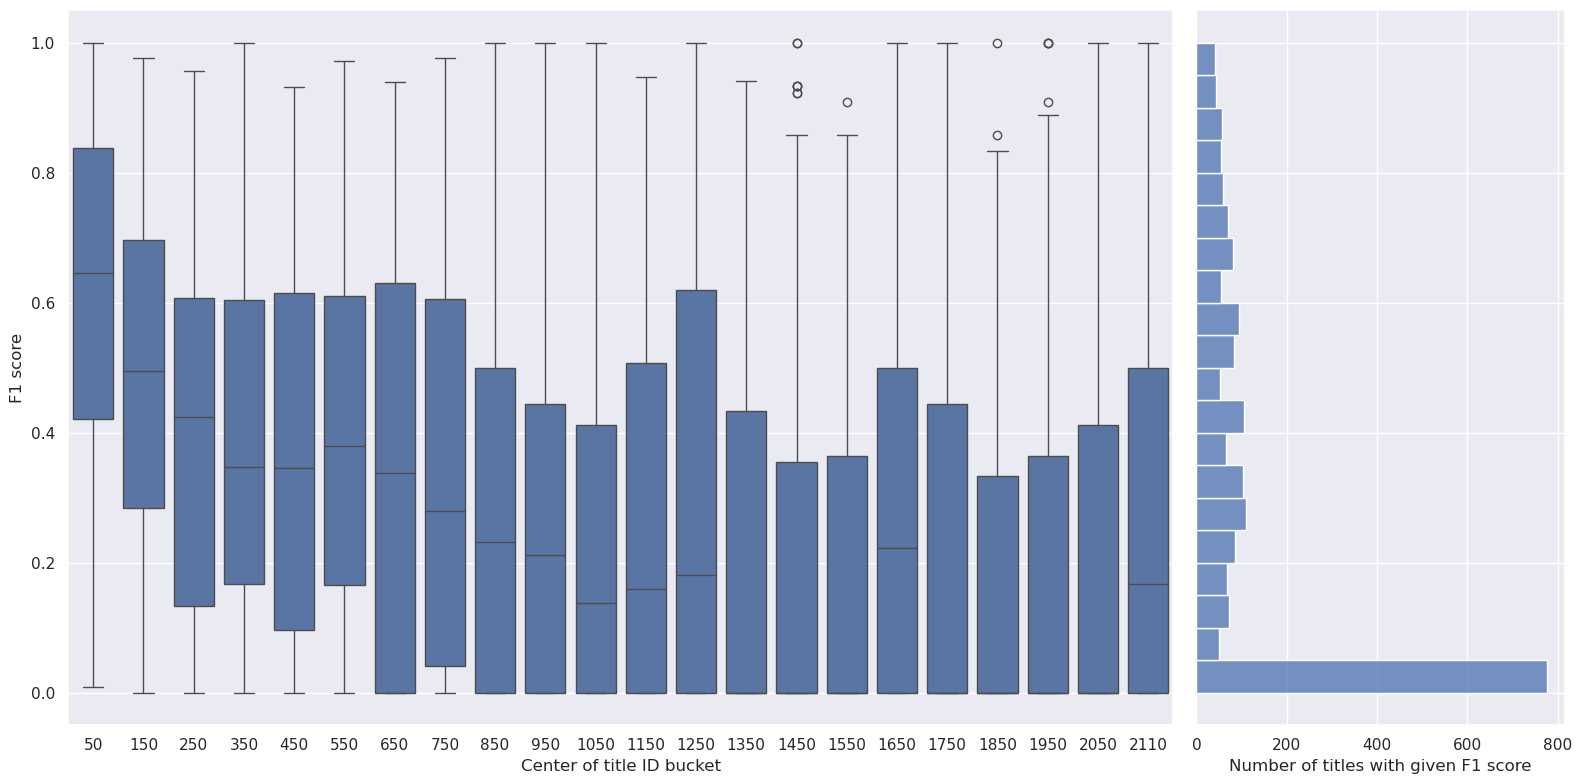

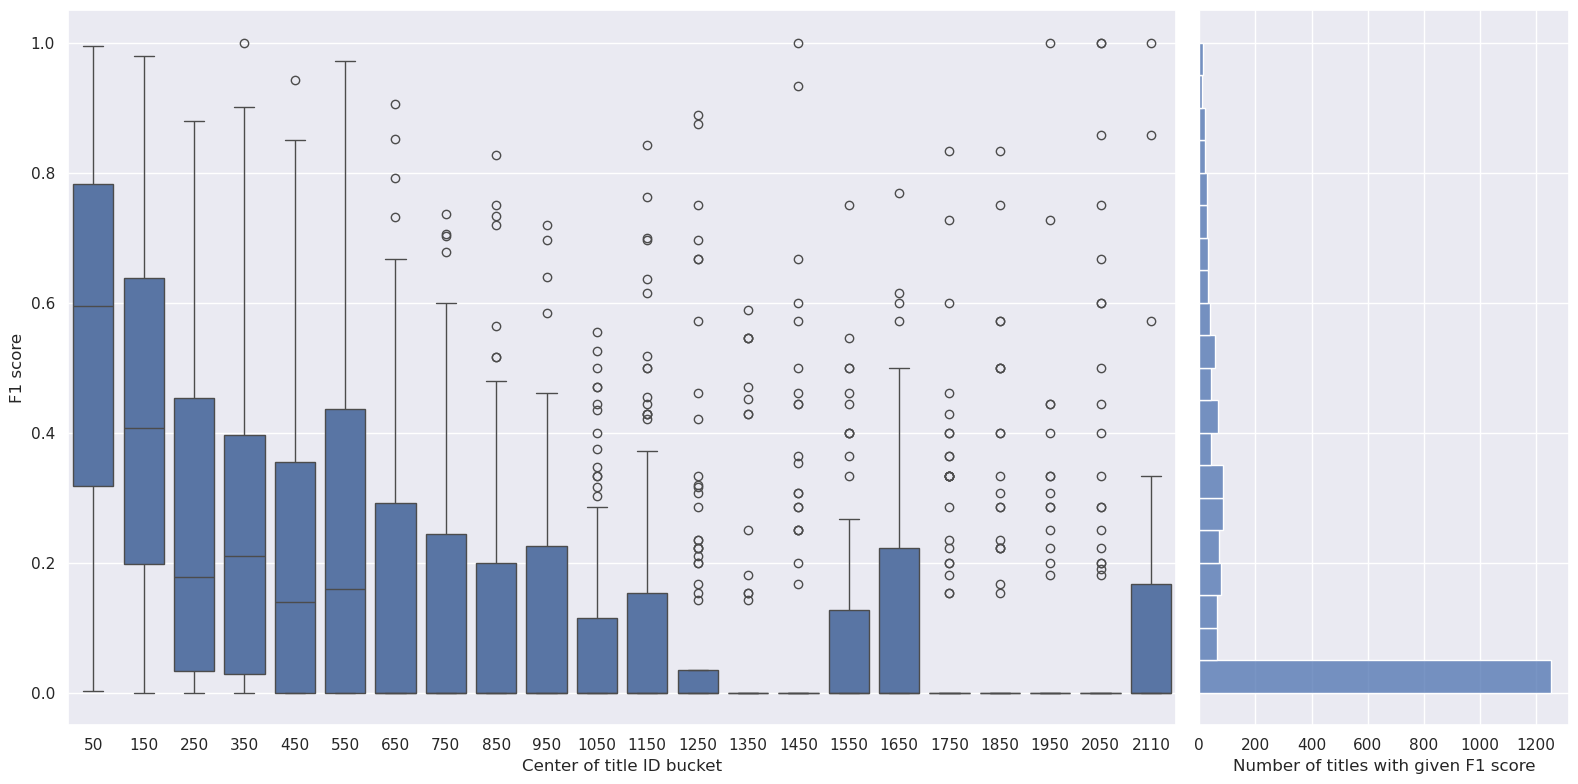

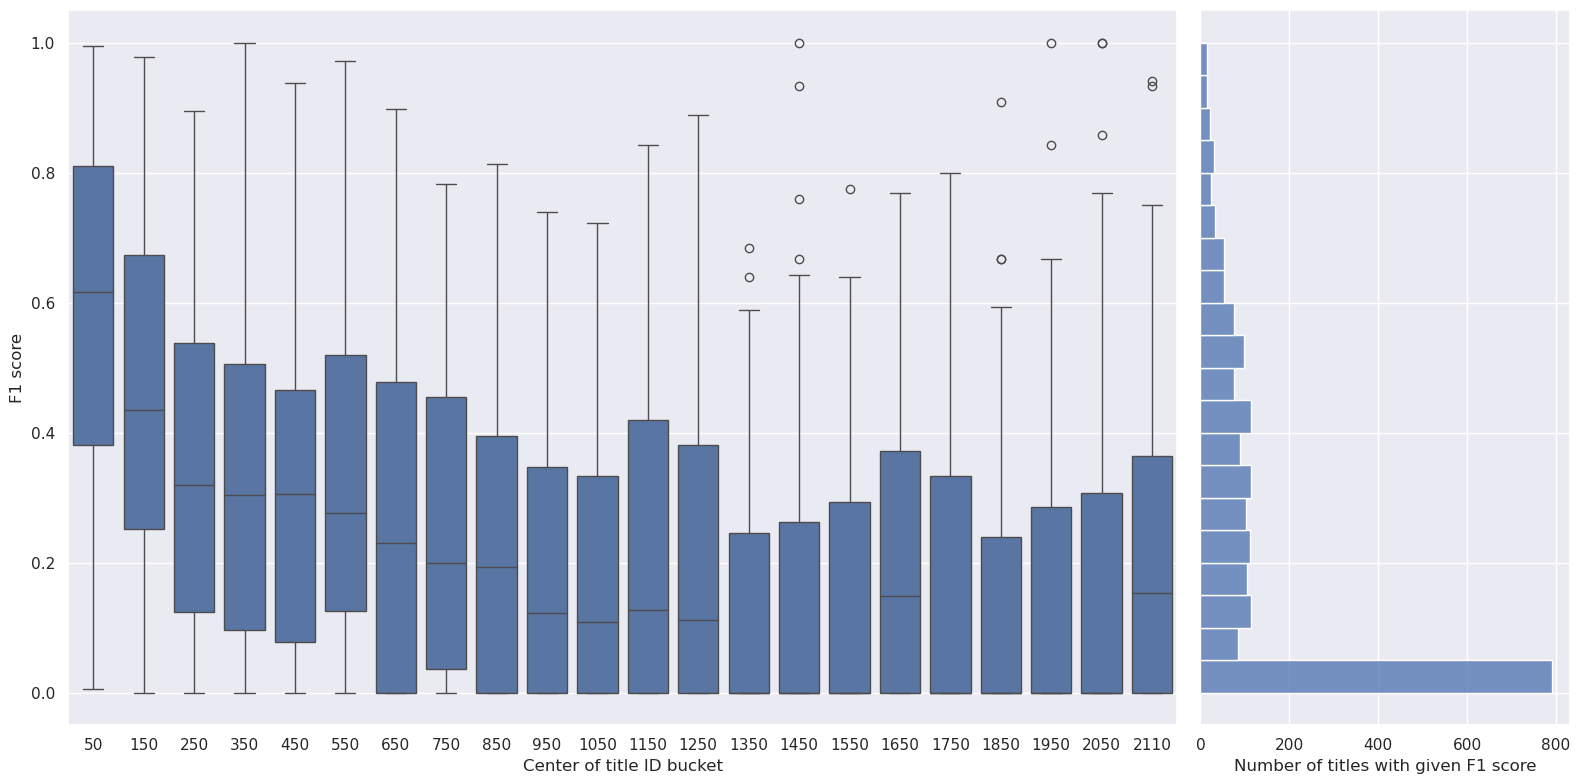

In [40]:
model_fcn = lambda x: nn_lsa.predict(x, batch_size=512, verbose=0)
create_metrics(model_fcn, vectors_lsa_test, ds["test"]["label"], f"{outname}-lsa", 100000)

### Doc2Vec - Classification

Make Doc2Vec vectors

In [41]:
class TqdmProgress(CallbackAny2Vec):
    def __init__(self, total, inc=1, **kwargs):
        self.pbar = tqdm(total=total, **kwargs)
        self.inc = inc
    def on_epoch_end(self, model):
        self.pbar.update(self.inc)
    def on_train_end(self, model):
        self.pbar.close()

In [42]:
def make_tagged_document(row):
    return TaggedDocument(row["doc"], [row["label"]])

Vectorize the data

In [43]:
window=5
min_count=5
workers=4 
epochs=10

In [44]:
tqdm.pandas(desc=f'  > Tagging documments')
x = ds["train"].progress_apply(make_tagged_document, axis=1)

  > Tagging documments:   0%|          | 0/3761672 [00:00<?, ?it/s]

In [45]:
tqdmcb = TqdmProgress(epochs, desc="  > Training doc2vec, epoch")
model = Doc2Vec(
    x.to_list(), vector_size=dim, window=window,
    min_count=min_count, workers=workers, epochs=epochs,
    callbacks=[tqdmcb]
)

  > Training doc2vec, epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
tqdm.pandas(desc=f'  > Infering train vectors')
vectors_train_doc2vec = ds["train"].doc.progress_apply(model.infer_vector)

  > Infering train vectors:   0%|          | 0/3761672 [00:00<?, ?it/s]

In [47]:
tqdm.pandas(desc=f'  > Infering test vectors')
vectors_test_doc2vec = ds["test"].doc.progress_apply(model.infer_vector)

  > Infering test vectors:   0%|          | 0/940420 [00:00<?, ?it/s]

Classification with Doc2Vec

In [48]:
nn_d2v = make_model(vectors_train_doc2vec, len(titles), dropout=0.0)
nn_d2v.summary()

nn_d2v.fit(
    x=np.stack(vectors_train_doc2vec), y=ds["train"].label,
    batch_size=512,
    epochs=10,
    validation_split=0.1,
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 2121)           │       273,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,137 (1.07 MB)

 Trainable params: 280,137 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.2563 - loss: 3.8163 - val_accuracy: 0.2371 - val_loss: 3.5747
Epoch 2/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.3974 - loss: 2.8256 - val_accuracy: 0.2657 - val_loss: 3.4227
Epoch 3/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4244 - loss: 2.6608 - val_accuracy: 0.2886 - val_loss: 3.3156
Epoch 4/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4417 - loss: 2.5619 - val_accuracy: 0.3038 - val_loss: 3.2544
Epoch 5/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4531 - loss: 2.5001 - val_accuracy: 0.3111 - val_loss: 3.2187
Epoch 6/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4607 - loss: 2.4588 - val_accuracy: 0.3177 - val_loss: 3.1895
Epoch 7/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4652 - loss: 2.4324 - val_accuracy: 0.3190 - val_loss: 3.1799
Epoch 8/10
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.4699 - loss: 2

In [51]:
vectors_test_doc2vec = np.stack(vectors_test_doc2vec.values).astype(np.float32)

> Making Doc2Vec Predictions


Calculating metrics: 100%|██████████| 10/10 [03:02<00:00, 18.29s/it]


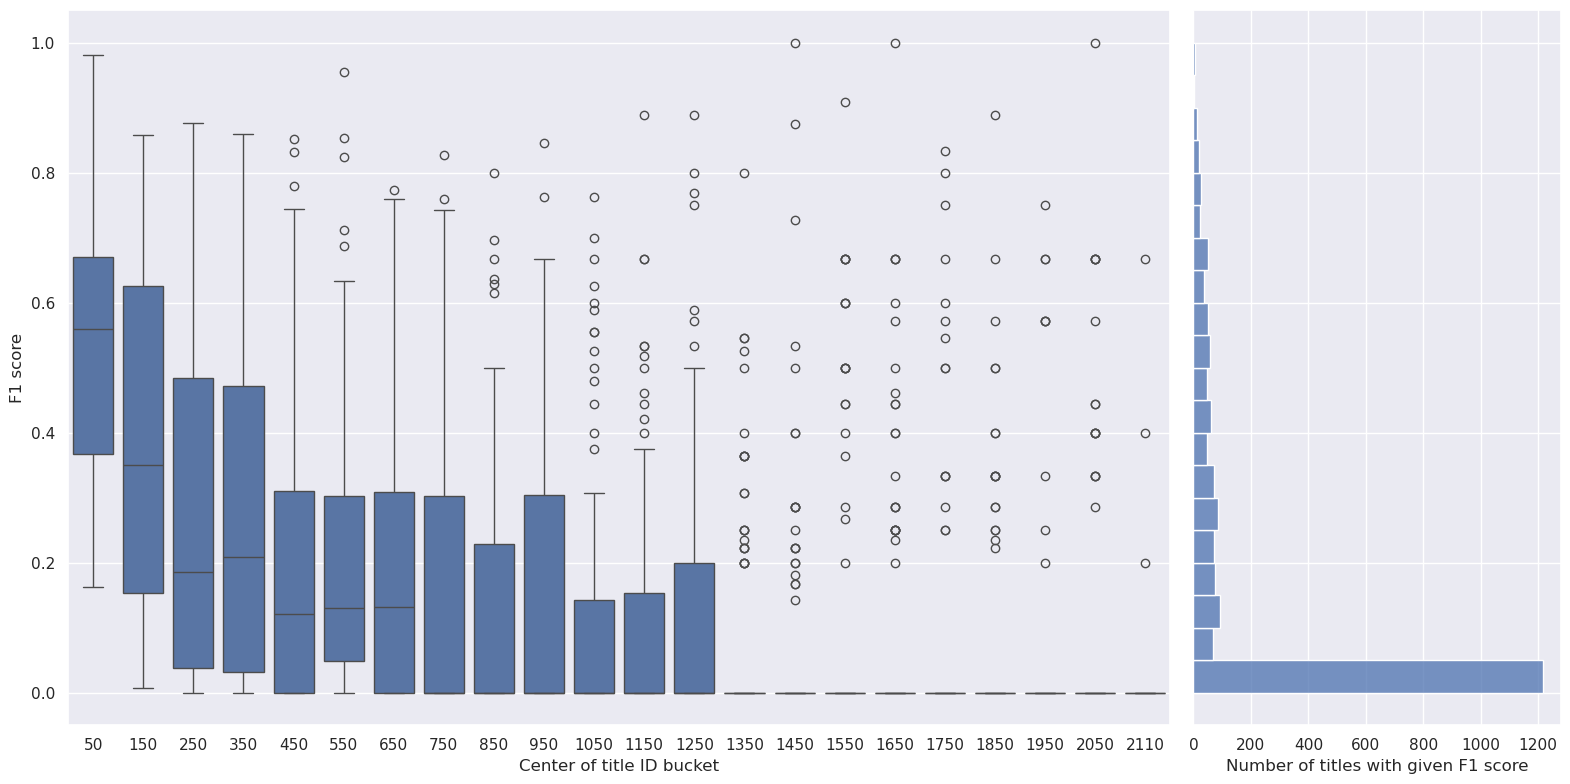

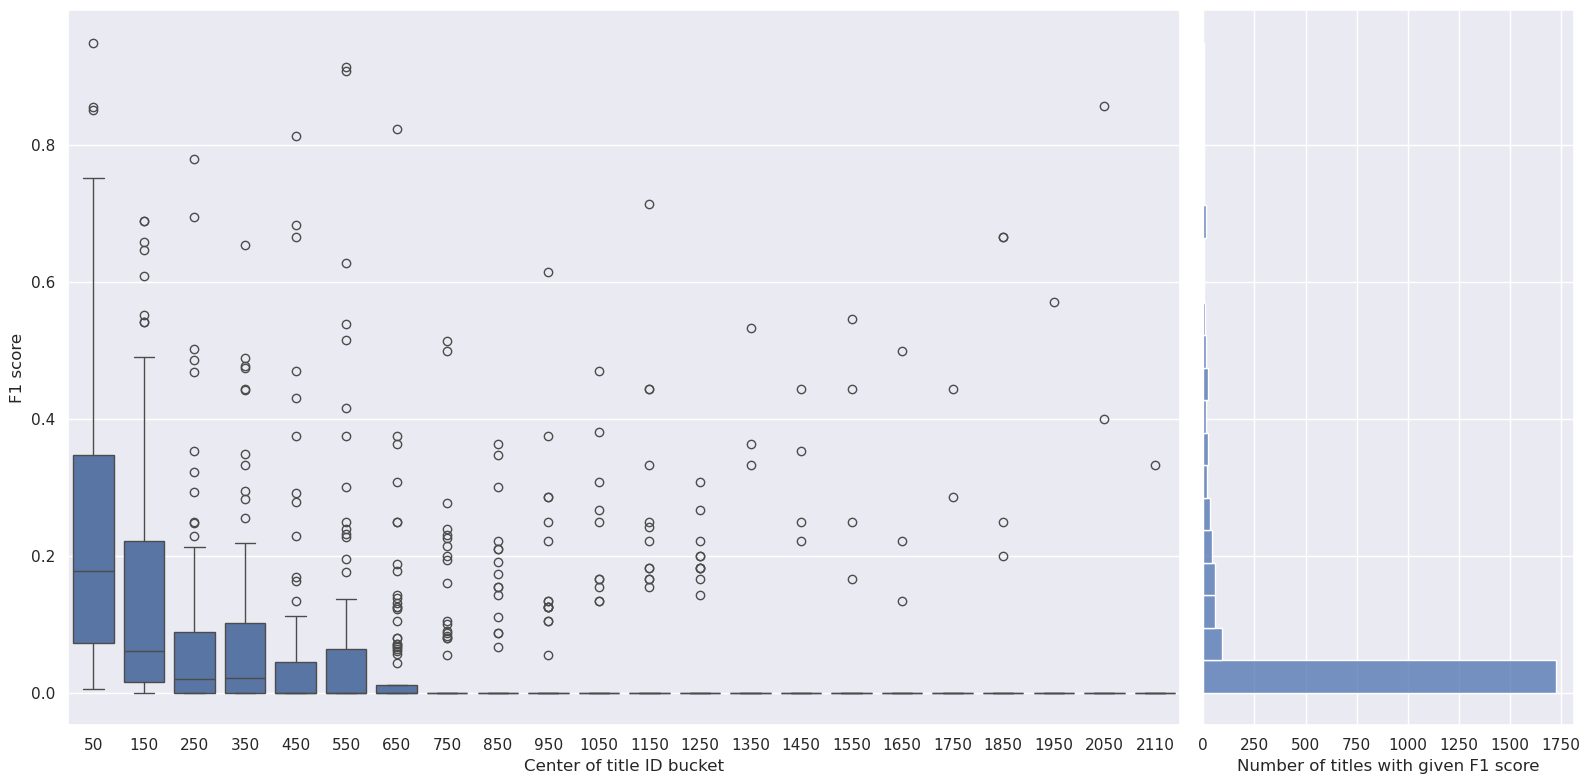

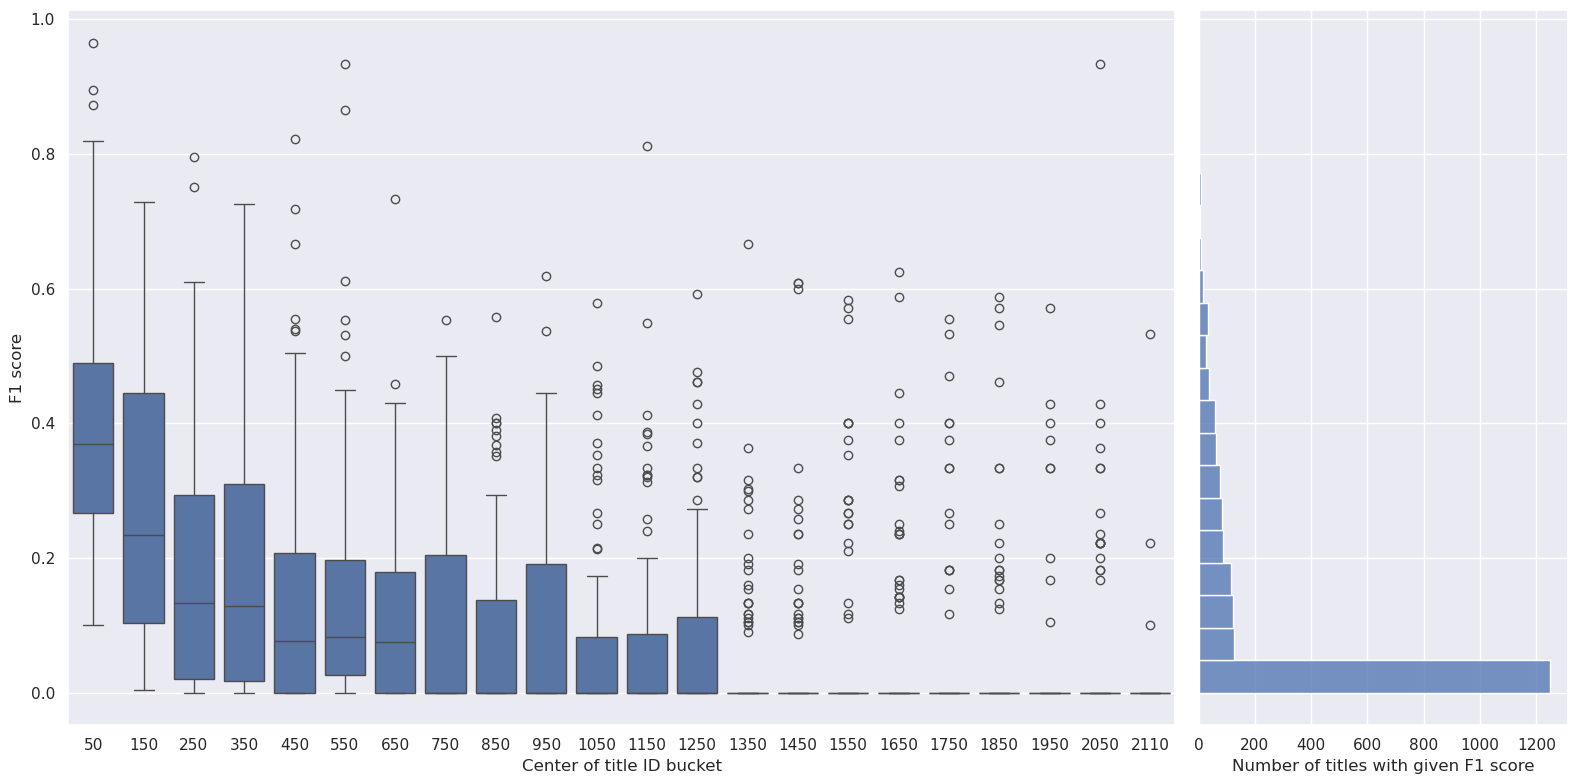

In [52]:
print("> Making Doc2Vec Predictions")
model_fcn = lambda x: nn_d2v.predict(x, batch_size=512, verbose=0)
create_metrics(model_fcn, vectors_test_doc2vec, ds["test"]["label"], f"{outname}-d2v", 100000)